In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mediapy as media
import torch

from ember.util import PROJECT_ROOT
from ember.zed import ZedRecording, ZedLive

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyzing IMU Data with Bayesian Methods
IMU data is notoriously noisy, requiring calibration to correct for initial offsets and filtering to minimize noise.

In this notebook, we will:
1. Analyze the noise and "un-calibrated" properties of recorded data.
2. Demonstrate the effect of bayes filtering (kalman) on reducing integration error. 

In [ ]:
# Load ZED recording
frames = []
with ZedRecording(PROJECT_ROOT / "data/zed_recordings/HD720_SN33087127_15-44-16.svo2") as zed:
    for frame in zed:
        frames.append(frame)

        if len(frames) == 100:
            break

# Parse IMU data into tensors
linear_acceleration = torch.as_tensor([frame.linear_acceleration for frame in frames])
angular_velocity = torch.as_tensor([frame.angular_velocity for frame in frames])

linear_acceleration[:, 1] += 9.81

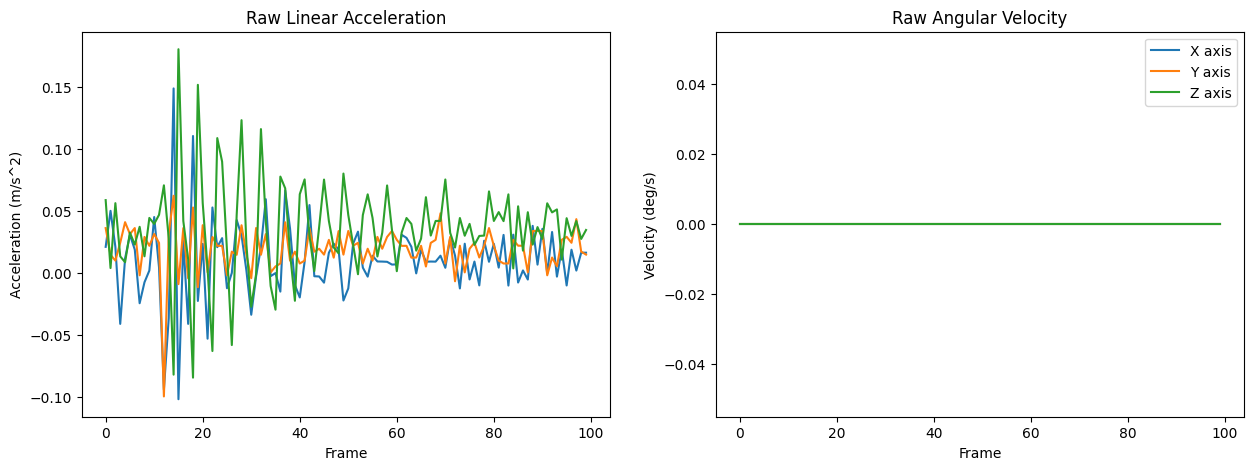

In [ ]:
# Plot raw IMU data
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, axis in enumerate(['X', 'Y', 'Z']):
    axs[0].plot(linear_acceleration[:, i], label=f'{axis} axis')
    axs[0].set_title('Raw Linear Acceleration')
    axs[0].set_xlabel('Frame')
    axs[0].set_ylabel('Acceleration (m/s^2)')

    axs[1].plot(angular_velocity[:, i], label=f'{axis} axis')
    axs[1].set_title('Raw Angular Velocity')
    axs[1].set_xlabel('Frame')
    axs[1].set_ylabel('Velocity (deg/s)')

plt.legend()
plt.show()

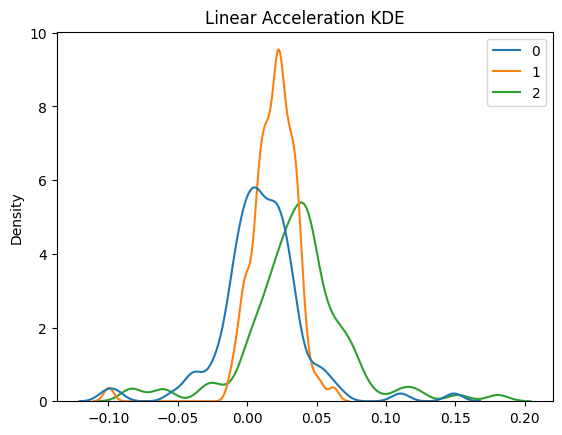

In [ ]:
plt.title('Linear Acceleration KDE')
sns.kdeplot(linear_acceleration.numpy(), bw_adjust=0.5)
plt.show()

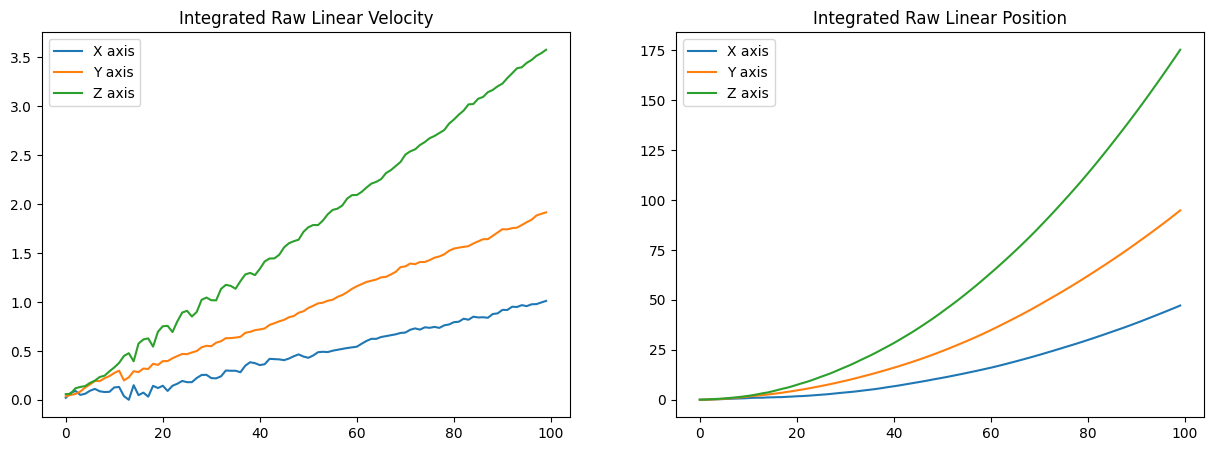

In [39]:
# Integrate raw (unfiltered) linear acceleration to get linear velocity
integrated_raw_linear_velocity = torch.cumsum(linear_acceleration, dim=0)
integrated_raw_linear_position = torch.cumsum(integrated_raw_linear_velocity, dim=0)

plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
ax.set_title('Integrated Raw Linear Velocity')
ax.plot(integrated_raw_linear_velocity[:, 0], label='X axis')
ax.plot(integrated_raw_linear_velocity[:, 1], label='Y axis')
ax.plot(integrated_raw_linear_velocity[:, 2], label='Z axis')
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.set_title('Integrated Raw Linear Position')
plt.plot(integrated_raw_linear_position[:, 0], label='X axis')
plt.plot(integrated_raw_linear_position[:, 1], label='Y axis')
plt.plot(integrated_raw_linear_position[:, 2], label='Z axis')
plt.legend()
plt.show()